# Introduction
- Trong bài viết này chủ yếu tìm hiểu về các mô hình dự đoán cho kiểu dữ liệu dạng time series đặc biệt cho bài toán time series forecasting
- Bài viết sẽ giới thiệu các phần : 
    1. PACF và ACF: là các hyperparameter trong việc xây dựng mô hình 
    2. Giới thiệu về các mô hình AR (auto regression) và mô hình MA (moving average)
    3. Xây dựng mô hình ARMA và ARIMA 
- Dữ liệu chính được sử dụng cho bài toán là giá cổ phiếu của META trong khoảng từ 2015 - 2023

In [26]:
import numpy as np 
import pandas as pd 
import talib as ta 
import matplotlib.pyplot as plt


In [27]:
# import pandas_datareader.data as web 
# from datetime import datetime
# import yfinance as yf  

# yf.pdr_override()
# start = datetime(2015, 1, 1)
# end = datetime(2024, 1, 1)

# data = web.get_data_yahoo('GOOG', start, end )
# data.info()


data = pd.read_csv('..\Data\META_15_23.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2264 non-null   object 
 1   Open       2264 non-null   float64
 2   High       2264 non-null   float64
 3   Low        2264 non-null   float64
 4   Close      2264 non-null   float64
 5   Adj Close  2264 non-null   float64
 6   Volume     2264 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 123.9+ KB


In [28]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
1,2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2,2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
3,2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
4,2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641


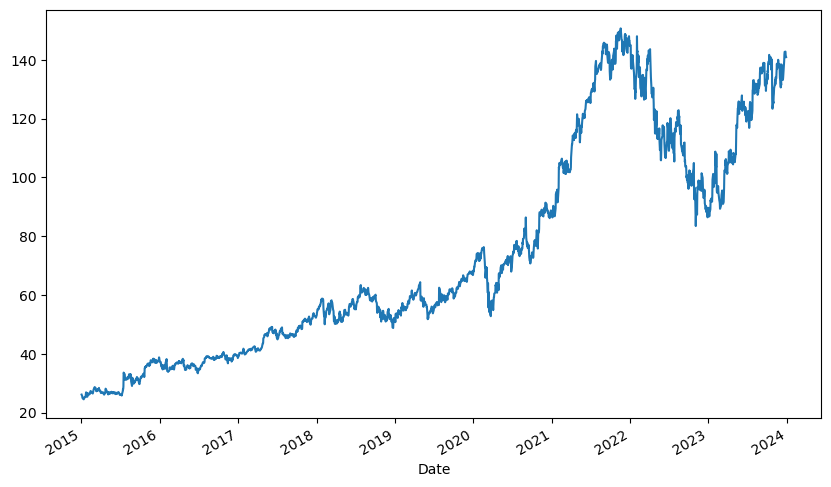

In [29]:
data.index = pd.to_datetime(data['Date'])
data.drop(['Date'], inplace = True, axis = 1)

plt.figure(figsize = (10, 6))
data['Close'].plot()
plt.show()

In [30]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641


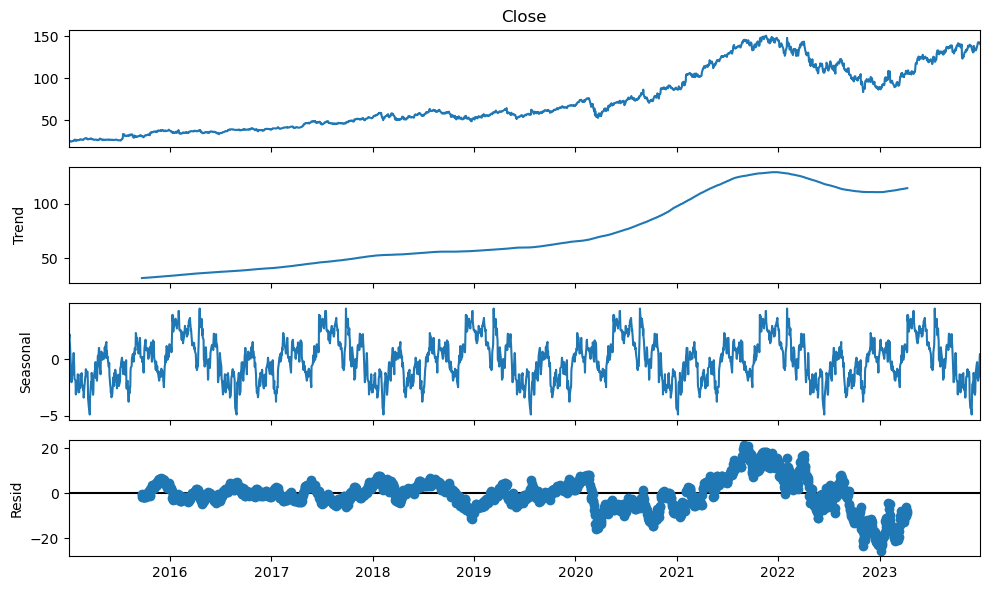

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose 
meta_seasonal_decompose =  seasonal_decompose(x = data['Close'], model = "additive", period = 365)
plt.rcParams['figure.figsize'] = (10, 6)
meta_seasonal_decompose.plot()

plt.show()

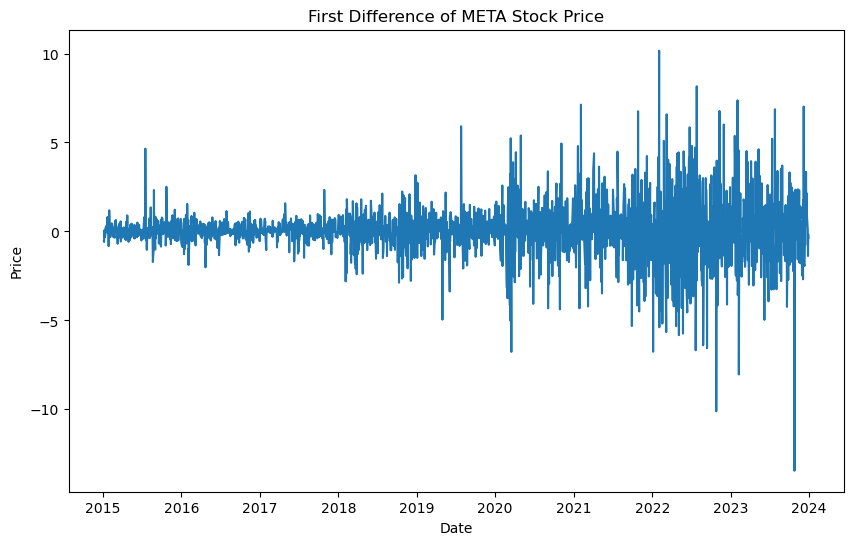

In [32]:
first_diff = data['Close'].diff()

plt.figure(figsize = (10, 6))
plt.plot(first_diff)
plt.title("First Difference of META Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2264 non-null   float64
 1   High       2264 non-null   float64
 2   Low        2264 non-null   float64
 3   Close      2264 non-null   float64
 4   Adj Close  2264 non-null   float64
 5   Volume     2264 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.8 KB


- Kiểm tra first_order có phải chuỗi đứng yên hay không ? 

In [34]:
from statsmodels.tsa.stattools import adfuller 

def test_stationary(data): 
    adfuller_output = adfuller(data)
    decision = "Non-Stationary"
    if adfuller_output[1] <= 0.05:
        decision = "Stationary"
    
    return pd.Series(data = {'Test Statistic': adfuller_output[0], 'p-value': adfuller_output[1], 'Number of lags': adfuller_output[2], 'Decision': decision})

test_stationary(first_diff.dropna())

Test Statistic    -11.861782
p-value                  0.0
Number of lags            21
Decision          Stationary
dtype: object

# 2. Autocorrelation và Partial Autocorrelation
- Autocorrelation là phép tính corr giữa biến $X_{n}$ và biến $X_{n-k}$. Nó cho biết mỗi tương quan giữa điểm giá trị thứ n và k điểm giá trị phía sau của nó. Nó ước tính mỗi quan hệ phụ thuộc trực tiếp và gián tiếp giữa các biến trong một khoảng thời gian

- Partial Autocorrelation là phép tính corr giữa $X_{n}$ và $X_{n-k}$, trừ đi các corr giữa $X_{n}$ và $X_{n-m}$, với m khác k. Nó loại bỏ đi sự phụ thuộc gián tiếp và chỉ quan tâm tới phụ thuộc chức tiếp giữa các giá trị trong một khoảng thời gian

(-0.25, 0.25)

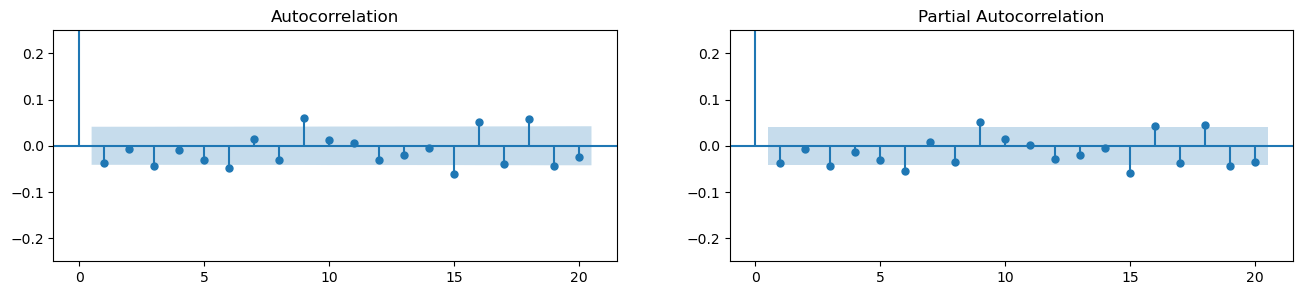

In [35]:
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(x = (data['Close']).diff().dropna(), lags=20, ax=axes[0])
plot_pacf(x =  (data['Close']).diff().dropna(), lags = 20,  ax=axes[1] )
axes[1].set_ylim(-0.25, 0.25)
axes[0].set_ylim(-0.25, 0.25)

- Phép kiểm thử autocorrelation trong time series : Người ta sử dụng Ljung-Box test cho việc kiểm tra autocorelation với một lag cụ thể. Null hypothesis trong phép kiểm thử này là độ trễ trước đó không tương quan với giá trị hiện tại 

In [36]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# chuyển data thành stationary và kiểm thử
acorr_ljungbox(x = np.log(data['Close']).diff().dropna(), lags = 100, return_df=True)

,lb_stat,lb_pvalue
1,5.714906,0.016821
2,5.803940,0.054915
3,6.890175,0.075482
4,7.735371,0.101767
5,8.133404,0.149035
...,...,...
96,158.320503,0.000065
97,170.806089,0.000006
98,171.074848,0.000007
99,171.199854,0.000009


- Phân chia dữ liệu :

In [37]:
from datetime import datetime

first_diff.dropna(inplace = True)

end_train_time = datetime(2023, 1, 1)

train_data = first_diff[: end_train_time]
test_data = first_diff[end_train_time:]

# 3. Mô hình Auto Regression (AR)
- Mô hình AR là mô hình dự đoán giá trị tương lai dựa trên giá trị trong quá khứ. Mô hình tương tự như mô hình linear regression : $$ \hat{y_{t}} = \beta_{1} y_{t - 1} + \beta_{2} y_{t - 2} + \beta_{3} y_{t - 3} + ..... $$ 
- Tham số q trong mô hình chỉ số lượng biến phụ thuộc trong quá khứ. Để xác định tham số này, người ta dựa vào biểu đồ PACF. Vậy lựa chọn tham số này như thế nào ?
- Người ta xem xét một số điều kiện sau: 
    1. Đỉnh (spike): Nếu giá trị lag vượt qua vùng có ý nghĩa và càng cao hoặc càng thấp (tức là có độ phụ thuộc lớn vào biến hiện tại)
    2. Cut off : Biểu đồ giảm mạnh về 0 sau một độ trễ k nhất định 
    3. Tail off : Biểu đồ giảm dần về 0 sau độ trễ k 
- Dựa vào biểu đồ PACF trên, ta lựa chọn q = 9 

In [38]:
train_data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2013 entries, 2015-01-05 to 2022-12-30
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2013 non-null   float64
dtypes: float64(1)
memory usage: 31.5 KB


In [51]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train_data, lags = 6)

model_fit =  model.fit()

c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [52]:
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 2013
Model:                     AutoReg(6)   Log Likelihood               -3543.136
Method:               Conditional MLE   S.D. of innovations              1.414
Date:                Wed, 17 Apr 2024   AIC                           7102.272
Time:                        23:41:34   BIC                           7147.107
Sample:                             6   HQIC                          7118.731
                                 2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0385      0.032      1.216      0.224      -0.024       0.100
Close.L1      -0.0600      0.022     -2.690      0.007      -0.104      -0.016
Close.L2      -0.0076      0.022     -0.341      0.7

In [53]:
# Specify the forecast horizon


start_date = len(test_data)
end_date = len(test_data)

# Predict unseen data
predictions = model_fit.predict(start=len(train_data),end=(len(train_data)+len(test_data) -1), dynamic=False)
predictions.index = test_data.index
residuals = test_data - predictions

c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


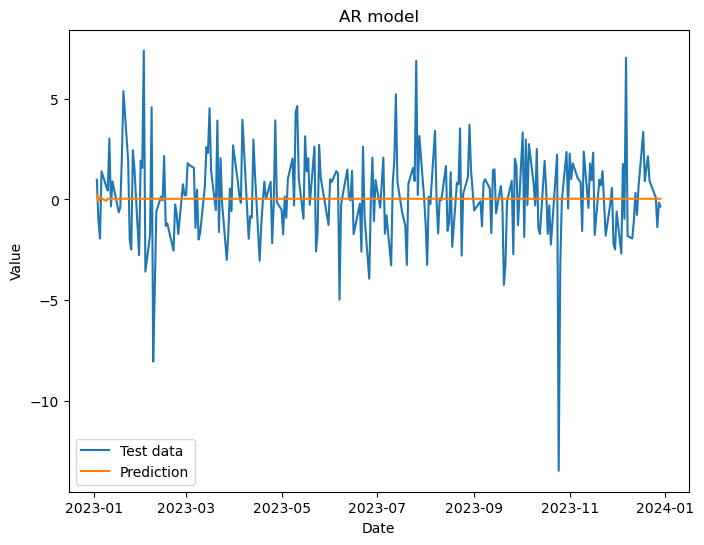

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(test_data, label='Test data')
plt.plot(predictions, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('AR model')
plt.legend()
plt.show()

In [55]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.2541108719138077


In [56]:
print('Mean Absolute Percent Error: ', round(np.mean((abs(residuals/test_data))), 4))

Mean Absolute Percent Error:  1.0178


# 4. Mô hình MA 
- Mô hình MA là mô hình dự đoán giá trị tương lai dựa vào giá trị error bao gồm cả error hiện tại $( \epsilon_{t}, \epsilon_{t - 1}, \epsilon_{t - 2}, ....)$ Mô hình có dạng : $$ y_{t} = \epsilon_{t} + \sum^{p}_{1} \beta_{i} \epsilon_{t - i} $$ 
- Số lượng các giá trị phụ thuộc được lựa chọn bởi đồ thị ACF, dựa vào biểu đồ trên, ta lựa chọn p = 9 

In [57]:
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(train_data, order=(0, 0, 6))
model_fit = model.fit()

print(model_fit.summary())

c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2013
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -3551.364
Date:                Wed, 17 Apr 2024   AIC                           7118.728
Time:                        23:42:36   BIC                           7163.587
Sample:                             0   HQIC                          7135.194
                               - 2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0312      0.027      1.160      0.246      -0.022       0.084
ma.L1         -0.0593      0.014     -4.146      0.000      -0.087      -0.031
ma.L2         -0.0073      0.014     -0.528      0.5

In [58]:

predictions = model_fit.predict(start=len(train_data),end=(len(train_data)+len(test_data) -1), dynamic=False)
predictions.index = test_data.index
residuals = test_data - predictions

c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


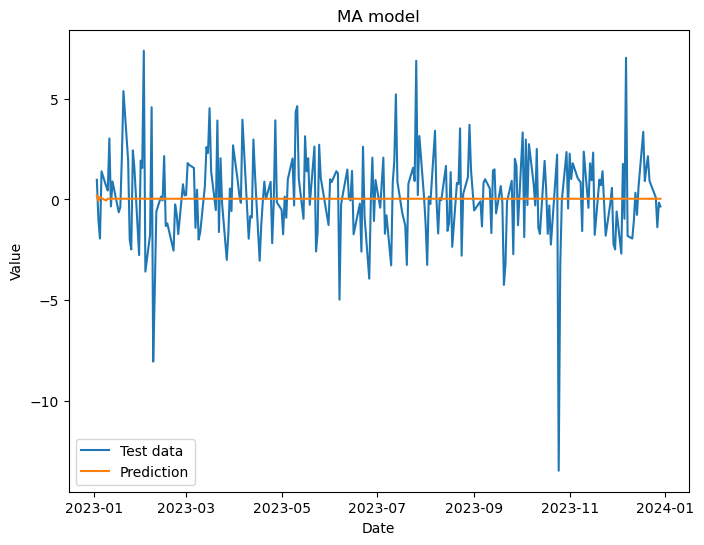

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(test_data, label='Test data')
plt.plot(predictions, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('MA model')
plt.legend()
plt.show()

In [60]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.2541514956260036


In [61]:
print('Mean Absolute Percent Error: ', round(np.mean((abs(residuals/test_data))), 4))

Mean Absolute Percent Error:  1.0171


# 5. Mô hình ARMA 
- Mô hình ARMA là kết hợp giữa hai mô hình AR và MA. 
- Mô hình có công thức : $$ y_t = \beta_0 + \sum \beta_{i} y_{ t - i} + \epsilon_{0} + \sum \theta_{i} \epsilon_{t - i} \ $$
- Tham số của mô hình (hyperparameter) bao gồm p, q là các tham số của mô hình AR và MA 
- Ta lựa chọn giá trị p = q = 9 

In [62]:
model = ARIMA(train_data, order=(9, 0, 9))
model_fit = model.fit()

print(model_fit.summary())

c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2013
Model:                 ARIMA(9, 0, 9)   Log Likelihood               -3529.448
Date:                Thu, 18 Apr 2024   AIC                           7098.895
Time:                        00:05:39   BIC                           7211.043
Sample:                             0   HQIC                          7140.060
                               - 2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0326      0.026      1.245      0.213      -0.019       0.084
ar.L1         -1.0490      0.089    -11.832      0.000      -1.223      -0.875
ar.L2         -0.0675      0.138     -0.490      0.6

In [63]:
predictions = model_fit.predict(start=len(train_data),end=(len(train_data)+len(test_data) -1), dynamic=False)
predictions.index = test_data.index
residuals = test_data - predictions

c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\anaconda3\envs\algo_trading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


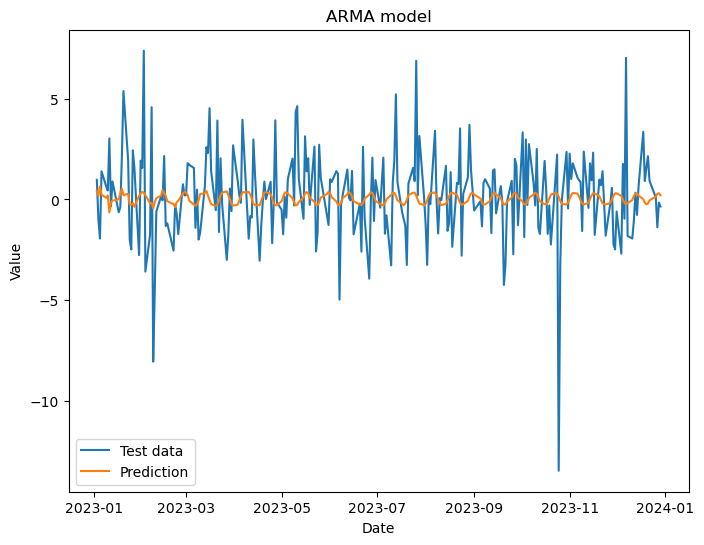

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(test_data, label='Test data')
plt.plot(predictions, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARMA model')
plt.legend()
plt.show()

In [68]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.2514025303274026


In [69]:
print('Mean Absolute Percent Error: ', round(np.mean((abs(residuals/test_data))), 4))

Mean Absolute Percent Error:  1.2721
